In [1]:
from netCDF4 import Dataset
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage import gaussian_filter1d
from scipy import signal
import cartopy.crs as ccrs
import cartopy
import ipywidgets as widgets
from ipywidgets import interact
from sklearn.cluster import KMeans
from itertools import groupby


Bad key "text.kerning_factor" on line 4 in
/home/silvia/.conda/envs/Hacking/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
ds_solar = xr.open_dataset('../data/Solar_forcing_1st_mill.nc')
ds_volc = xr.open_dataset('../data/Volc_Forc_AOD_1st_mill.nc')
ds_temp_r1 = xr.open_dataset('../data/T2m_R1_ym_1stMill.nc')

In [10]:
# remove the volcanic eruption data + 5 year post volcanic time window -> remove 243 years
eruption_years = np.nonzero(ds_volc.AOD.values.flatten())[0]
years_to_be_removed = []
for yr in eruption_years:
    years_to_be_removed.append(np.arange(yr, yr+6, 1))
years_to_be_removed = np.asarray(years_to_be_removed)
years_to_be_removed = years_to_be_removed.reshape((np.shape(years_to_be_removed)[0]*np.shape(years_to_be_removed)[1]))
years_to_be_removed.sort()
years_to_be_removed = [x[0] for x in groupby(years_to_be_removed)]
years_to_be_removed = np.asarray(years_to_be_removed)
years_to_be_removed = years_to_be_removed[years_to_be_removed < 999]

volcanic_boolean_array = np.ones(np.shape(ds_volc.AOD.values.flatten()), dtype=bool)
volcanic_boolean_array[years_to_be_removed] = 0

kept_years = np.arange(1, 1000, 1)
kept_years = kept_years[volcanic_boolean_array]

temp = ds_temp_r1['T2m'].values
temp = temp[volcanic_boolean_array, :, :]

In [6]:
# compare wih clustering on relative changes of temperature (difference to temperature of previous year)

X_rel = temp.copy()
print(np.shape(X_rel))
X_rel = X_rel.reshape(756, -1).transpose()
for i in np.arange(1, 756):
    X_rel[:, i] = X_rel[:, i] - X_rel[:, i-1]
X_rel = X_rel[:, 1:]
kmeans_rel = KMeans(n_clusters=10, random_state=0).fit(X_rel)

(756, 96, 192)


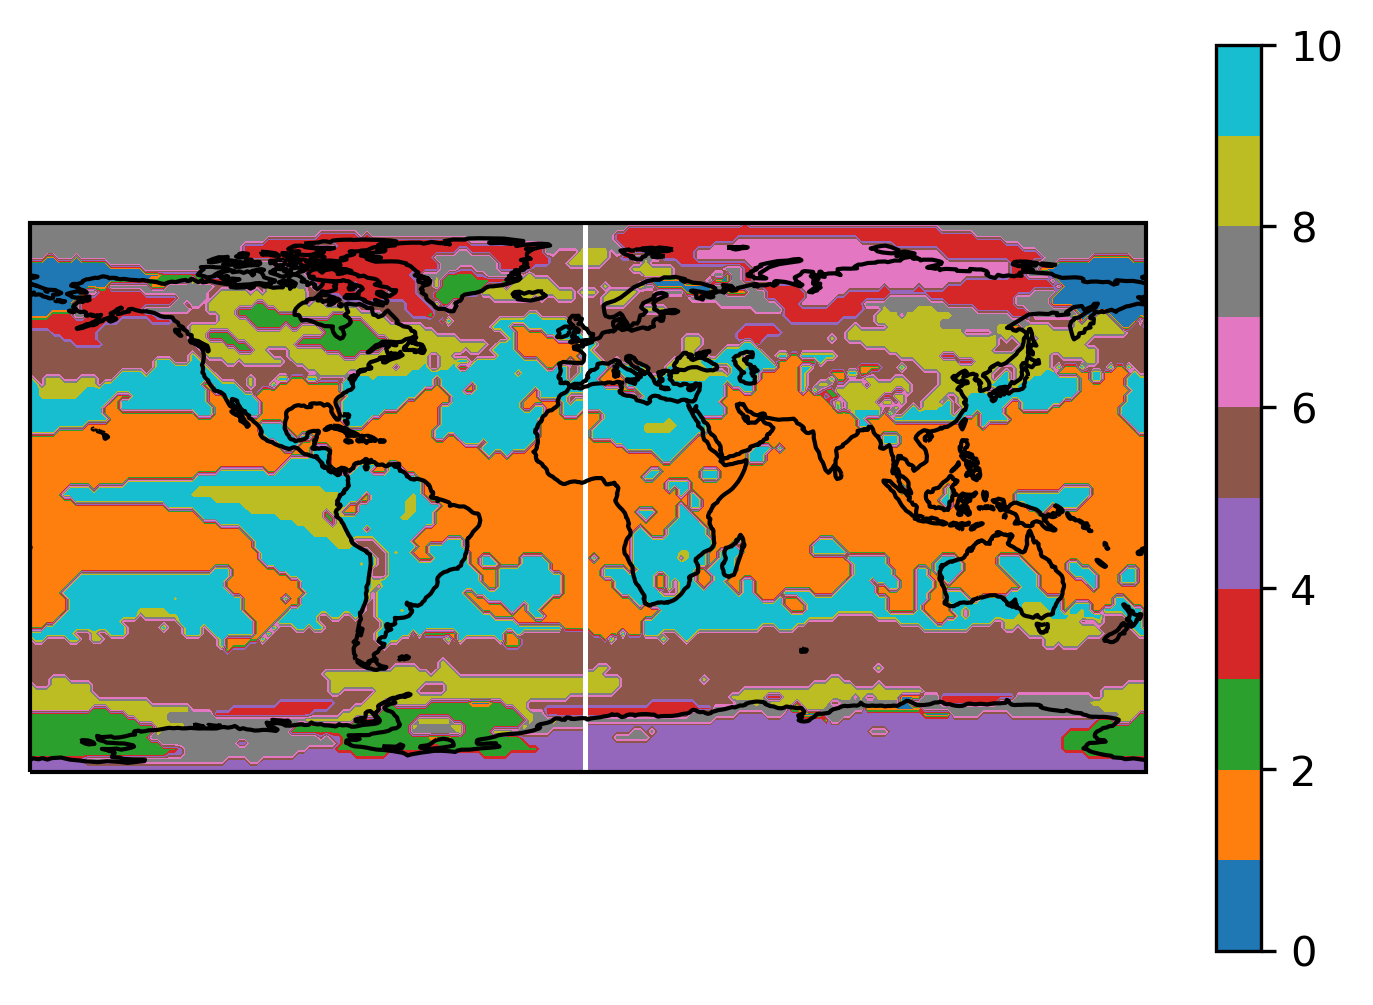

In [7]:
clusters_rel = kmeans_rel.labels_.reshape(96, 192)
lats = ds_temp_r1.variables['lat'][:]
lons = ds_temp_r1.variables['lon'][:]

fig, ax = plt.subplots(1, 1, dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree())

cs = plt.contourf(lons, lats, clusters_rel+0.5, 9, transform=ccrs.PlateCarree(), cmap=cm.tab10)

ax.coastlines()
fig.colorbar(cs)

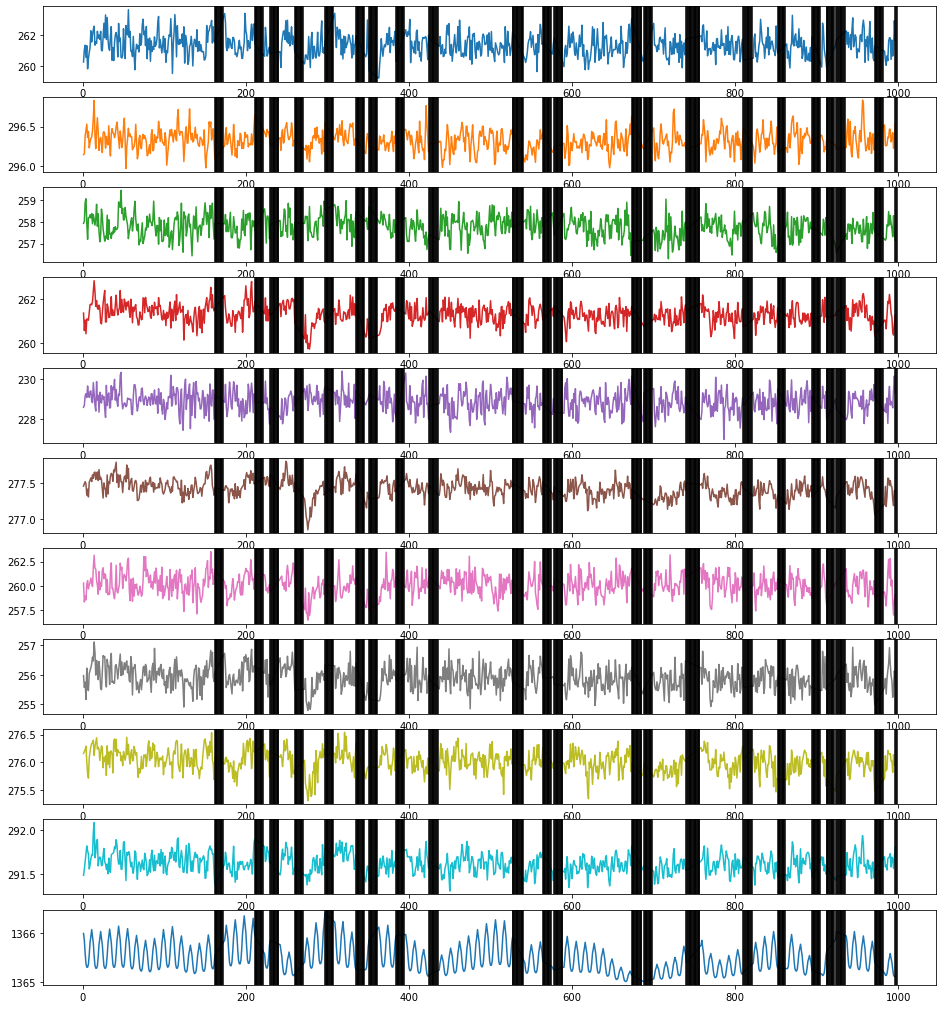

In [21]:
mean_temp_clusters = []
for c in np.unique(clusters_rel):
    temps_cluster = temp[:, clusters_rel == c]
    temps_cluster = np.mean(temps_cluster, axis=1)
    mean_temp_clusters.append(temps_cluster)
    
# solar irradiance for kept years
kept_sol = ds_solar.TSI.values.flatten()[volcanic_boolean_array]

fig, axes = plt.subplots(11, 1, figsize=(16, 18))
for i, ax in enumerate(axes.flatten()):
    if i<10:
        ax.plot(kept_years, mean_temp_clusters[i], color=cm.tab10((i+0.5)/10))
        for y in years_to_be_removed:
            ax.axvline(x=y, ymin=0, ymax=1, c='k')
    else:
        ax.plot(kept_years, kept_sol)
        for y in years_to_be_removed:
            ax.axvline(x=y, ymin=0, ymax=1, c='k')